# Classification: Cats VS Dogs

We downloaded the dataset from kaggle. The training archive contains 25,000 images of dogs and cats. 

# Using own data with included Datasets

In [1]:
import os
import mxnet as mx
import matplotlib.pyplot as plt
from mxnet import gluon
from mxnet import nd, autograd
import numpy as np

In [2]:
def aug_transform(data, label):
    data = data.astype('float32')/255 # normalize the data
    size= 224
    aug = mx.image.ForceResizeAug((size,size)) # resize the image to 224x224
    data = aug(data)
    data=data.transpose((2, 0, 1))
    return data, label

# Reading Training date

In [3]:
data_folder = "data"
dataset_name = "CatsVsDogs"

training_path = os.path.join(data_folder, dataset_name)
print(training_path)

train_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(training_path,transform=aug_transform)



data/CatsVsDogs


In [4]:
sample_idx = 17990
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

#plt.imshow(data.asnumpy(), cmap='gray')
print("Data type: {}".format(data.shape))
print("Label: {}".format(label))
print("Label description: {}".format(train_dataset.synsets[label]))
assert label == 1

Data type: (3, 224, 224)
Label: 1
Label description: dog


# Test data

In [5]:
testing_path = os.path.join(data_folder, "{}_test".format(dataset_name))
print(testing_path)
test_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(testing_path,transform=aug_transform)

data/CatsVsDogs_test


In [6]:
sample_idx = 199

sample = test_dataset[sample_idx]
data = sample[0]
label = sample[1]

#plt.imshow(data.asnumpy(), cmap='gray')
print("Data type: {}".format(data.shape))
print("Label: {}".format(label))
print("Label description: {}".format(train_dataset.synsets[label]))

Data type: (3, 224, 224)
Label: 0
Label description: cat


# Batch size and DataLoader for train_data, test_dataset

In [7]:
batch_size = 128
train_data = gluon.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_dataset,batch_size, shuffle=False)

# The AlexNet architecture

In [8]:
alex_net = gluon.nn.HybridSequential()
with alex_net.name_scope():
    #  First convolutional layer
    alex_net.add(gluon.nn.Conv2D(64, kernel_size=11, strides=4,padding=2, activation='relu'))    
    alex_net.add(gluon.nn.MaxPool2D(pool_size=3, strides=2))
    #  Second convolutional layer
    alex_net.add(gluon.nn.Conv2D(192, kernel_size=5, padding=2, activation='relu'))
    alex_net.add(gluon.nn.MaxPool2D(pool_size=3, strides=2))
    # Third convolutional layer
    alex_net.add(gluon.nn.Conv2D(384, kernel_size=3, padding=1, activation='relu'))
    # Fourth convolutional layer
    alex_net.add(gluon.nn.Conv2D(256, kernel_size=3, padding=1, activation='relu'))
    # Fifth convolutional layer
    alex_net.add(gluon.nn.Conv2D(256, kernel_size=3, padding=1, activation='relu'))
    alex_net.add(gluon.nn.MaxPool2D(pool_size=3, strides=2))
     # Flatten and apply fullly connected layers
    alex_net.add(gluon.nn.Flatten())
    alex_net.add(gluon.nn.Dense(4096, activation='relu'))
    alex_net.add(gluon.nn.Dropout(0.5))
    alex_net.add(gluon.nn.Dense(4096, activation='relu'))
    alex_net.add(gluon.nn.Dropout(0.5))
    alex_net.add(gluon.nn.Dense(2))
            
    

# Initialize parameters

In [9]:
ctx = mx.gpu()
alex_net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

# Optimizer 

In [10]:
trainer = gluon.Trainer(alex_net.collect_params(), 'adam', {'learning_rate': .0001})

# Softmax cross-entropy loss

In [11]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

# Evaluation Loop

In [12]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    curr_loss= []
    for d, l in data_iterator:
        data = d.as_in_context(ctx)
        label = l.as_in_context(ctx)
        output = net(data)
        
        loss = softmax_cross_entropy(output, label)
        
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=[predictions], labels=[label])
        
        curr_loss.append(nd.mean(loss).asscalar())
        
        #print(acc)
    
    return acc.get()[1], np.average(curr_loss)

# Training loop

In [13]:
epochs = 10
smoothing_constant = .1
metric = mx.metric.Accuracy()

train_acc=[]
val_acc=[]

train_loss=[]
val_loss=[]


for e in range(epochs):
    metric.reset()
    for i, (d, l) in enumerate(train_data):
        data = d.as_in_context(ctx)
        label = l.as_in_context(ctx)
        with autograd.record():
            output = alex_net(data)
            loss = softmax_cross_entropy(output, label)
        
        loss.backward()
        trainer.step(data.shape[0])
                
        ##########################
        #  Keep a moving average of the losses
        ##########################
        metric.update([label], [output])
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)

        
        if i % 10 == 0 and i > 0:
                name, acc = metric.get()
                print('[Epoch %d Batch %d] Loss: %s Training %s=%f'%(e, i, moving_loss, name, acc))
           
    _, train_accuracy = metric.get()
    
    test_accuracy,test_loss = evaluate_accuracy(test_data, alex_net)
    
    train_acc.append(train_accuracy)
    val_acc.append(test_accuracy)
    
    train_loss.append(moving_loss)
    val_loss.append(test_loss)
    
    #_, train_accuracy = metric.get()
    #print("Epoch %s. Loss: %s, Train_acc %s\n" % (e, moving_loss, train_accuracy))

    #test_accuracy = evaluate_accuracy(test_data, alex_net)
    print("\nEpoch %s., Validation Accuracy %s,Validation Loss =%s \n" % (e, test_accuracy,val_loss[e]))

[Epoch 0 Batch 10] Loss: 0.6943047587383679 Training accuracy=0.489347
[Epoch 0 Batch 20] Loss: 0.6941533888310099 Training accuracy=0.496280
[Epoch 0 Batch 30] Loss: 0.6934086133143494 Training accuracy=0.503528
[Epoch 0 Batch 40] Loss: 0.6917674320050085 Training accuracy=0.518674
[Epoch 0 Batch 50] Loss: 0.688668707648033 Training accuracy=0.524357
[Epoch 0 Batch 60] Loss: 0.6792871089963084 Training accuracy=0.531762
[Epoch 0 Batch 70] Loss: 0.6720514663795649 Training accuracy=0.540163
[Epoch 0 Batch 80] Loss: 0.6633489719386878 Training accuracy=0.548708
[Epoch 0 Batch 90] Loss: 0.6580686605876566 Training accuracy=0.555288
[Epoch 0 Batch 100] Loss: 0.6615737169961216 Training accuracy=0.559406
[Epoch 0 Batch 110] Loss: 0.6591270890243752 Training accuracy=0.562852
[Epoch 0 Batch 120] Loss: 0.6337564839585329 Training accuracy=0.570958
[Epoch 0 Batch 130] Loss: 0.6436845138134603 Training accuracy=0.574129
[Epoch 0 Batch 140] Loss: 0.6419850874522944 Training accuracy=0.576795
[E

[Epoch 6 Batch 20] Loss: 0.17511518565934164 Training accuracy=0.935640
[Epoch 6 Batch 30] Loss: 0.19537335389077587 Training accuracy=0.931956
[Epoch 6 Batch 40] Loss: 0.18498035282305542 Training accuracy=0.930450
[Epoch 6 Batch 50] Loss: 0.1712485451325485 Training accuracy=0.929841
[Epoch 6 Batch 60] Loss: 0.20934820933824477 Training accuracy=0.925333
[Epoch 6 Batch 70] Loss: 0.18812905779482567 Training accuracy=0.926496
[Epoch 6 Batch 80] Loss: 0.21616478275837292 Training accuracy=0.923997
[Epoch 6 Batch 90] Loss: 0.20578348095706003 Training accuracy=0.923506
[Epoch 6 Batch 100] Loss: 0.2085615125554502 Training accuracy=0.922339
[Epoch 6 Batch 110] Loss: 0.2223714164288311 Training accuracy=0.921453
[Epoch 6 Batch 120] Loss: 0.20278805651200216 Training accuracy=0.921875
[Epoch 6 Batch 130] Loss: 0.20469627122841197 Training accuracy=0.921756
[Epoch 6 Batch 140] Loss: 0.20583120210508407 Training accuracy=0.921487
[Epoch 6 Batch 150] Loss: 0.1957406504324681 Training accuracy

# Plot Loss and Accuracy

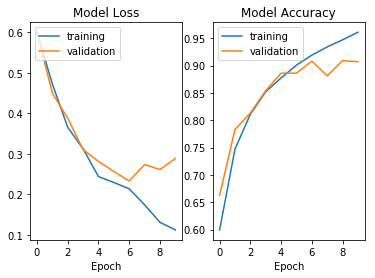

In [15]:
plt.ion()
fig = plt.figure()
subfig=fig.add_subplot(122)
subfig.plot(train_acc, label = 'training')
if val_acc is not None:
    subfig.plot(val_acc, label = 'validation')
    
subfig.set_title('Model Accuracy')
subfig.set_xlabel('Epoch')
subfig.legend(loc='upper left')

subfig1=fig.add_subplot(121)
subfig1.plot(train_loss, label='training')
if val_loss is not None:
    subfig1.plot(val_loss, label = 'validation')
subfig1.set_title('Model Loss')
subfig1.set_xlabel('Epoch')
subfig1.legend(loc='upper left')
plt.ioff()
